In [1]:
from IPython.display import display
import os

if "SSH_CONNECTION" in os.environ:
    display("Running via SSH")
else:
    display("Running locally")

'Running via SSH'

In [2]:
import sys
import os

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/TB-PNCA-GNN') if "SSH_CONNECTION" not in os.environ else os.path.join('..', '/mnt/alphafold-volume-1/dylan2/repos/tb-pnca-gnn')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

import datetime
import random

import numpy as np
import pandas as pd
import copy

import torch
from torch_geometric.data import Data

import wandb

import MDAnalysis
from MDAnalysis.analysis.distances import distance_array

import networkx as nx

from tqdm import tqdm

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

from src import run_model, protein_graph, gcn_model, evaluation

%load_ext autoreload
%autoreload 2

%aimport src

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
torch.cuda.is_available()

True

### Create Train and Test Sequences from Carter paper

In [12]:
reference = gumpy.Genome('../data/NC_000962.3.gbk')
pnca = reference.build_gene('pncA')

In [13]:
# recreate train/test dataset from pncA paper
pnca_paper_dataset = pd.read_csv('../data/ds-traintest-phen.csv')
pnca_paper_dataset.CONSISTENT_PHENOTYPE.value_counts()

CONSISTENT_PHENOTYPE
R    349
S    315
Name: count, dtype: int64

In [14]:
def split_mutation(row):
    return pd.Series([row.MUTATION[0], int(row.MUTATION[1:-1]), row.MUTATION[-1]])

pnca_paper_dataset[['REF','AMINO_ACID','ALT']] = pnca_paper_dataset.apply(split_mutation,axis=1)

In [15]:
from sklearn.model_selection import train_test_split

mutations_dict = {}

mutations_dict['train'], mutations_dict['test'] = train_test_split(pnca_paper_dataset, test_size=0.3, random_state=42)

### Augment Train and Test datasets with SBMLSsim

In [16]:
def get_muts_list(df):
    r_list = list(df[df.CONSISTENT_PHENOTYPE=='R'].MUTATION.drop_duplicates())
    s_list = list(df[df.CONSISTENT_PHENOTYPE=='S'].MUTATION.drop_duplicates())
    r_list = ['pncA@' + x for x in r_list]
    s_list = ['pncA@' + x for x in s_list]
    return r_list, s_list

In [17]:
train_res_list, train_sus_list = get_muts_list(mutations_dict['train'])
test_res_list, test_sus_list = get_muts_list(mutations_dict['test'])

In [18]:
print('Num resistant mutations in train:',len(train_res_list), 'Num susceptible mutations in train', len(train_sus_list))
print('Num resistant mutations in test:', len(test_res_list), 'Num susceptible mutations in test:', len(test_sus_list))

Num resistant mutations in train: 246 Num susceptible mutations in train 218
Num resistant mutations in test: 103 Num susceptible mutations in test: 97


In [ ]:
train_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = train_res_list,
                        susceptible_mutations = train_sus_list,
                        genbank_file='../data/NC_000962.3.gbk'
                    )

test_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = test_res_list,
                        susceptible_mutations = test_sus_list,
                        genbank_file='../data/NC_000962.3.gbk'
                    )

In [10]:
seed = 42
np.random.seed(seed)
random.seed(seed)

n_samples = 10000

In [12]:
train_prop = len(train_res_list)/(len(train_res_list)+len(train_sus_list))
test_prop = len(test_res_list)/(len(test_res_list)+len(test_sus_list))

train_sequences, train_mutations = train_batch.generate(n_samples=int(n_samples*0.7),
                                                  proportion_resistant=train_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

test_sequences, test_mutations = test_batch.generate(n_samples=int(n_samples*0.3),
                                                  proportion_resistant=test_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

train_sequences.rename(columns = {'pncA':'allele'}, inplace=True)
test_sequences.rename(columns = {'pncA':'allele'}, inplace=True)

In [13]:
sequences_dict = {'train': train_sequences, 'test': test_sequences}

### Run

In [ ]:
# try with sgd, higher lr and no wd

In [21]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 256
hidden_channels = 64
learning_rate = 0.001
wd = 5e-5
epochs = 400

ews = 'none'

wt_seq = 'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS'

In [6]:
# # Create torch_geometric Data objects once to be reused each run

# pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
#                      lig_resname='PZA', 
#                      self_loops=False,
#                      cutoff_distance=cutoff_distance)

# pnca.gen_dataset(wt_seq=wt_seq,
#                     sequences=sequences_dict['train'],
#                     edge_weights=ews,
#                     normalise=True,             
#                     )
        
# train_dataset = pnca.dataset

# pnca.gen_dataset(wt_seq=wt_seq,
#             sequences=sequences_dict['test'],
#             edge_weights=ews,
#             normalise=True,             
#             )

# test_dataset = pnca.dataset
# full_dataset = train_dataset + test_dataset

# torch.save(full_dataset, 'full_dataset.pth')

In [7]:
full_dataset = torch.load('full_dataset.pth')

In [35]:
model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    # sequences=sequences_dict,
    sequences=None,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    dataset = full_dataset,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA Split Set',
        'wandb_name' : f'ES Simple GCN n_samples = {n_samples} AdamW',
        'n_samples' : n_samples
    }
)

Using CUDA


Early stopping enabled. Patience: 20 Min Delta: 0
Epoch: 010, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6905, Test Loss: 0.6914
Epoch: 020, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6907, Test Loss: 0.6920
Epoch: 030, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6891, Test Loss: 0.6903
Epoch: 040, Train Acc: 0.5273, Test Acc: 0.5180, Train Loss: 0.6854, Test Loss: 0.6867
Epoch: 050, Train Acc: 0.5280, Test Acc: 0.5193, Train Loss: 0.6803, Test Loss: 0.6841
Epoch: 060, Train Acc: 0.6056, Test Acc: 0.6010, Train Loss: 0.6695, Test Loss: 0.6714
Epoch: 070, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.7050, Test Loss: 0.7160
Epoch: 080, Train Acc: 0.6420, Test Acc: 0.6133, Train Loss: 0.6321, Test Loss: 0.6452
Epoch: 090, Train Acc: 0.7341, Test Acc: 0.7180, Train Loss: 0.5871, Test Loss: 0.6118
Epoch: 100, Train Acc: 0.5300, Test Acc: 0.5113, Train Loss: 0.5988, Test Loss: 0.6421
Epoch: 110, Train Acc: 0.7406, Test Acc: 0.7127, Train Loss: 0.5344, Test Loss: 

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test Accuracy,▁▁▁▁▁▁▁▁▁▂▁▂▁▁▇▁▁▁▁▅▆▆▅█▅▇▇▁▂▇███▇█▁▇█▇█
Test Loss,▅▅▅▅▅▅▅▅▄▄▄▄▅▄▄▄▄▃▄▂▃▂▂▃▃▁▁▆▂▁▃▁▂▂▄█▂▂▃▂
Train Accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▁▆▂▂▁▂▅▅▆▅▆▅▆▆▂▃▇▇██▆▇▂▇█▇█
Train Loss,█████████████▇▇█▇▆▇▆▆▅▅▆▅▄▄▆▅▃▄▃▃▄▃▆▂▁▃▂
Test Accuracy,0.75267
Test Loss,0.64391
Train Accuracy,0.84157
Train Loss,0.37321


In [36]:
# model.train_sequences = train_sequences
# model.train_mutations = train_mutations
# model.test_sequences = test_sequences
# model.test_mutations = test_mutations

# torch.save(model, f'saved_models/es_adamw_n{n_samples}_aug_split_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

In [5]:
model = torch.load('saved_models//es_adamw_n10000_aug_split_seed42_2024_11_28_140719')

In [7]:
model = model.to('cpu')

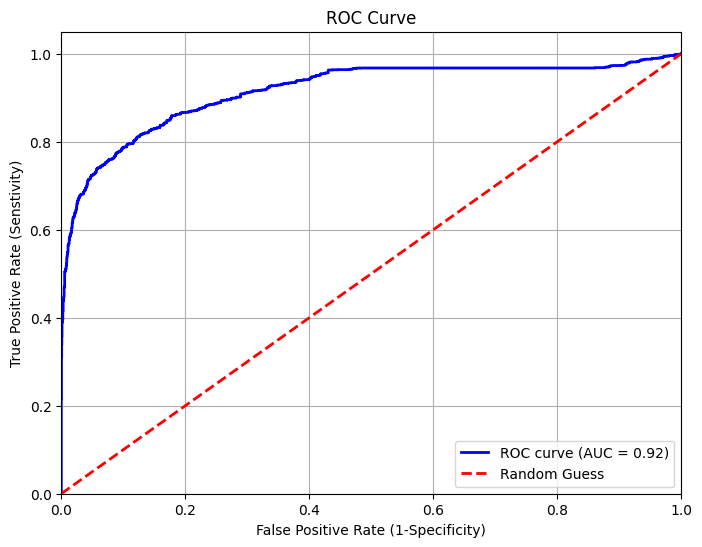

Number predicted resistant = 3461. Number labeled R = 3698
Number predicted susceptible = 3539. Number labeled S = 3302
Sensitivity: 0.82
Specificity: 0.87


(0.8180097349918876, 0.8679588128407026)

In [8]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.train_loader)

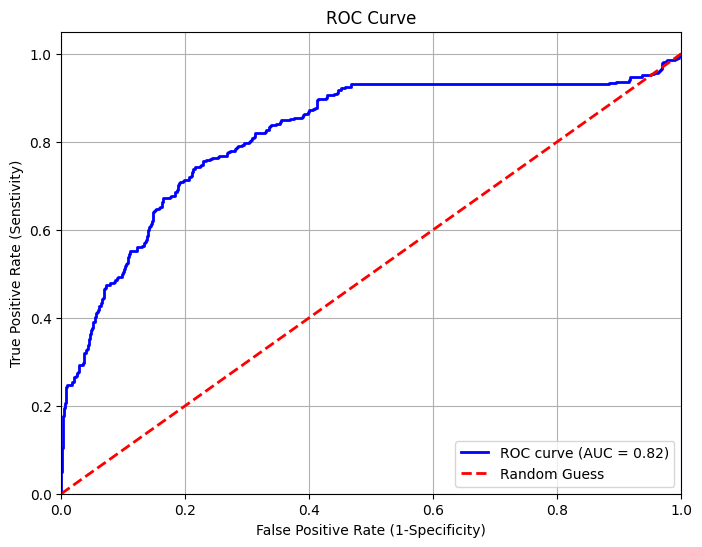

Number predicted resistant = 1626. Number labeled R = 1560
Number predicted susceptible = 1374. Number labeled S = 1440
Sensitivity: 0.78
Specificity: 0.72


(0.7833333333333333, 0.7194444444444444)

In [9]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.test_loader)

### Evaluate against raw set of mutations

In [10]:
def convert_mutations_to_samples(mutations_df):
    out_df = pd.DataFrame(columns=['phenotype_label','number_resistant_mutations', 'number_susceptible_mutations', 'allele'])

    for idx, row in mutations_df.iterrows():
    
        sample = copy.deepcopy(pnca)
        # reassign amino acid to mutated amino acid
        sample.amino_acid_sequence[sample.amino_acid_number==row.AMINO_ACID] = row.ALT
        
        sequence = ''.join(i for i in sample.amino_acid_sequence)
        
        if row.CONSISTENT_PHENOTYPE == 'R':
            number_resistant_mutations = 1
            number_susceptible_mutations = 0
            phenotype_label = 'R'
        else:
            number_resistant_mutations = 0
            number_susceptible_mutations = 1
            phenotype_label = 'S'
            
        out_df.loc[len(out_df)] = [phenotype_label, number_resistant_mutations, number_susceptible_mutations, sequence]
    
    return out_df

In [20]:
from torch_geometric.data import DataLoader

real_train_sequences = convert_mutations_to_samples(mutations_dict['train'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=6.3)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_train_sequences,
        edge_weights= 'none',
        normalise=False
        )

real_train_loader = DataLoader(real_pnca.dataset, batch_size=64, shuffle=True)

100%|██████████| 464/464 [00:26<00:00, 17.55it/s]


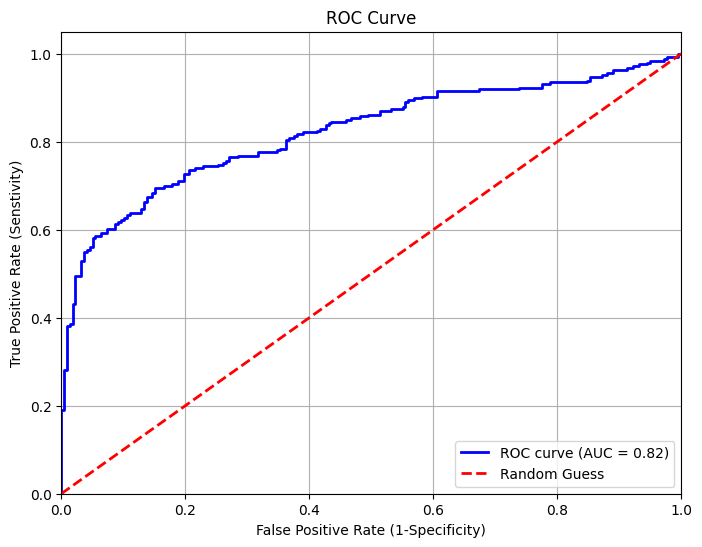

Number predicted resistant = 194. Number labeled R = 246
Number predicted susceptible = 270. Number labeled S = 218
Sensitivity: 0.67
Specificity: 0.86


(0.6666666666666666, 0.8623853211009175)

In [21]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_train_loader)

In [22]:
real_test_sequences = convert_mutations_to_samples(mutations_dict['test'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=6.3)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_test_sequences,
        edge_weights= 'none',
        normalise=False
        )

real_test_loader = DataLoader(real_pnca.dataset, batch_size=64, shuffle=True)

100%|██████████| 200/200 [00:11<00:00, 17.74it/s]


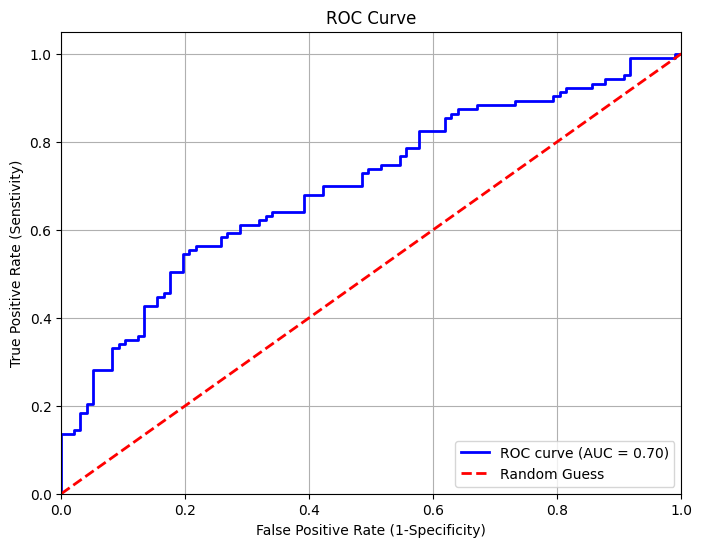

Number predicted resistant = 91. Number labeled R = 103
Number predicted susceptible = 109. Number labeled S = 97
Sensitivity: 0.61
Specificity: 0.71


(0.6116504854368932, 0.711340206185567)

In [23]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_test_loader)

### Rerun with 1 as output dim

In [14]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
output_channels = 1
learning_rate = 5e-5
wd = 1e-5
learning_rate = 1e-3
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=sequences_dict,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    output_channels = output_channels,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA outputdim = 1',
        'wandb_name' : f'test1',
        'n_samples' : n_samples
    }
)

100%|██████████| 3000/3000 [00:23<00:00, 129.66it/s]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch: 010, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6923
Epoch: 020, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 030, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6923
Epoch: 040, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6914, Test Loss: 0.6925
Epoch: 050, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6916, Test Loss: 0.6925
Epoch: 060, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 070, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 080, Train Acc: 0.4717, Test Acc: 0.4800, Train Loss: 0.6898, Test Loss: 0.6924
Epoch: 090, Train Acc: 0.4920, Test Acc: 0.4807, Train Loss: 0.6818, Test Loss: 0.6935
Epoch: 100, Train Acc: 0.5374, Test Acc: 0.4903, Train Loss: 0.6631, Test Loss: 0.6962
Epoch: 110, Train Acc: 0.5707, Test Acc: 0.5400, Train Loss: 0.6426, Test Loss: 0.6806
Epoch: 120, Train Acc: 0.5797, Test Acc: 0.

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test Accuracy,▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▃▆▇▇▇▇▇▄▆█▇█▄▇▃▅▄▅▆▇█▇█
Test Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▁▃▄▃▆▁▅▁▂▁▃▄▇▆▆█
Train Accuracy,▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▄▆▆▇▇▇▆▄▆▇▇█▅█▄▆▅▅▇████
Train Loss,██████████▇▇▆▆▆▆▆▆▄▄▃▂▃▃▅▄▅▃▁▅▁▅▄▅▄▂▁▁▂▁
Test Accuracy,0.67
Test Loss,1.63287
Train Accuracy,0.75943
Train Loss,0.46085


In [18]:
model.train_sequences = train_sequences
model.train_mutations = train_mutations
model.test_sequences = test_sequences
model.test_mutations = test_mutations

torch.save(model, f'saved_models/outputdim_1_n{n_samples}_aug_split_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

In [ ]:
# model = torch.load('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/tb-pnca-gnn/dd_pnca/saved_models/outputdim_1_n10000_aug_split_seed42_2024_11_25_133517')

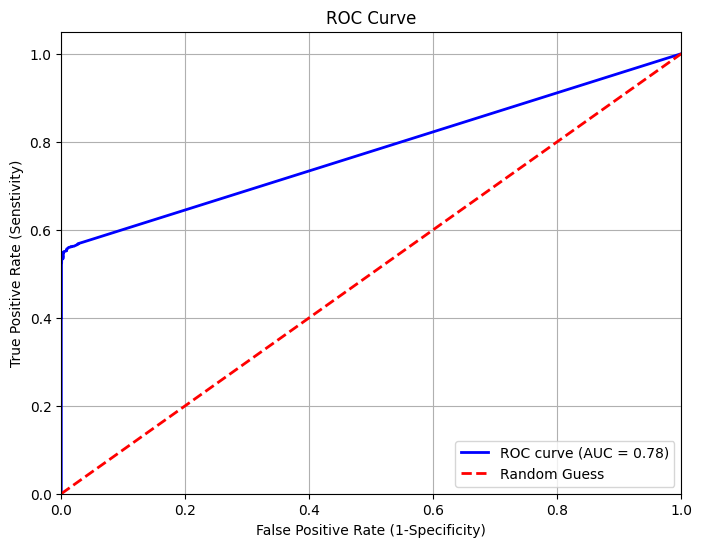

Number predicted resistant = 2038. Number labeled R = 3698
Number predicted susceptible = 4962. Number labeled S = 3302
Sensitivity: 0.55
Specificity: 1.00


(0.5478637101135749, 0.9963658388855239)

In [4]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.train_loader)

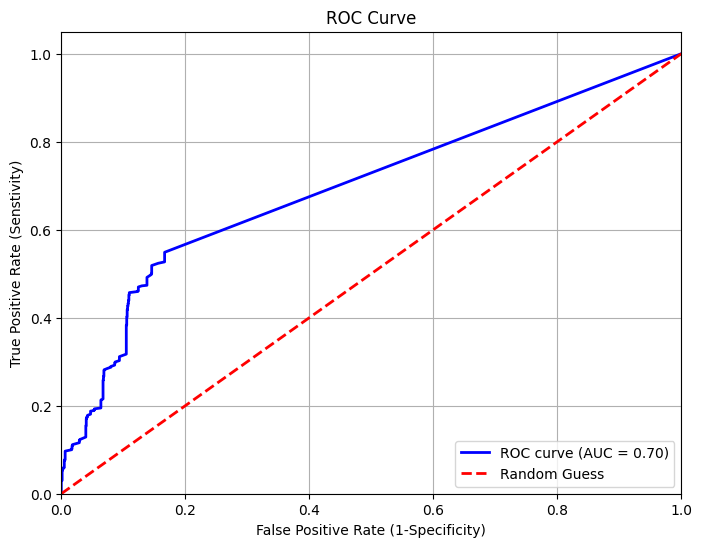

Number predicted resistant = 988. Number labeled R = 1560
Number predicted susceptible = 2012. Number labeled S = 1440
Sensitivity: 0.50
Specificity: 0.85


(0.49935897435897436, 0.8548611111111111)

In [5]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.test_loader)